In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
!pip install xgboost

In [71]:
import xgboost as xgb

In [72]:

df = pd.read_csv(r"C:\Users\levir\OneDrive\Desktop\DataSets\HourlyEnergyConsumption_Data\PJME_hourly.csv")
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

<AxesSubplot:title={'center':'PJME Energy use in MW'}, xlabel='Datetime'>

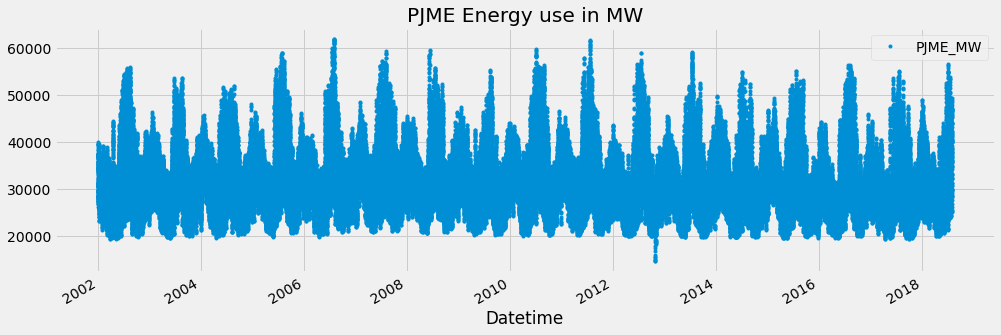

In [73]:
df.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJME Energy use in MW')

# Train / Test split

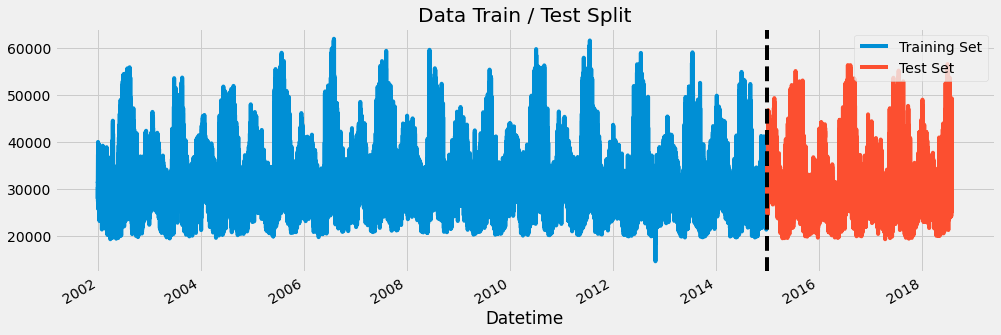

In [74]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fix, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', title='Data Train / Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

<AxesSubplot:title={'center':'Week of Data'}, xlabel='Datetime'>

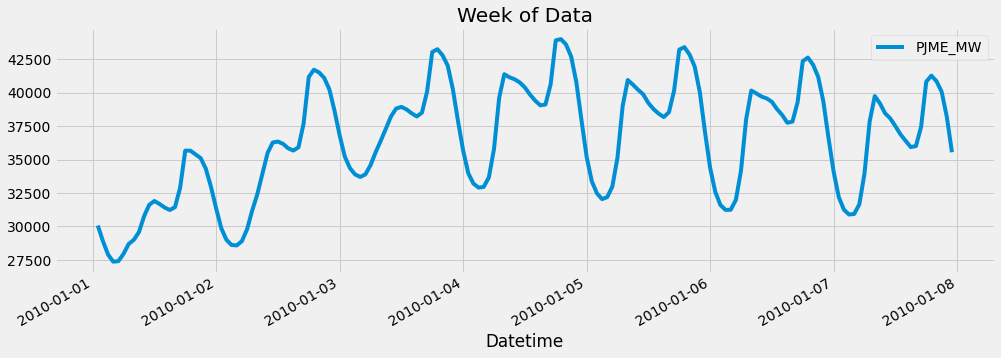

In [75]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15,5), title = 'Week of Data')

# Feature Creation

In [76]:
def create_features(df):
    """
    Creating time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

# Visualize our Feature / Target Relationship

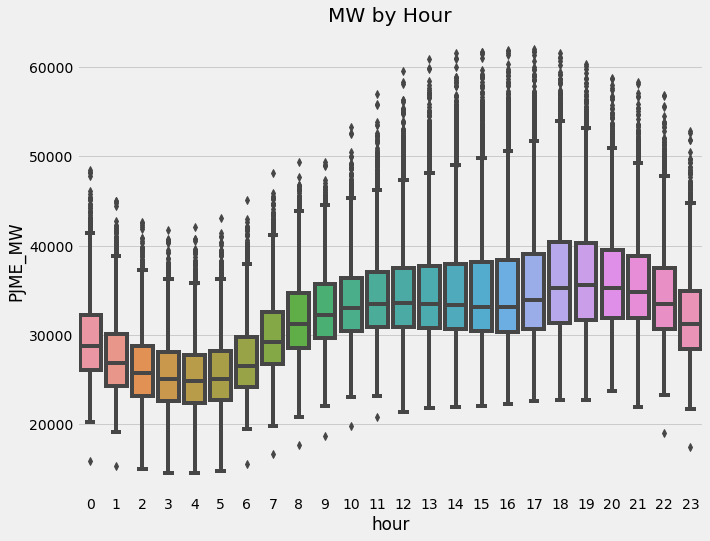

In [77]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

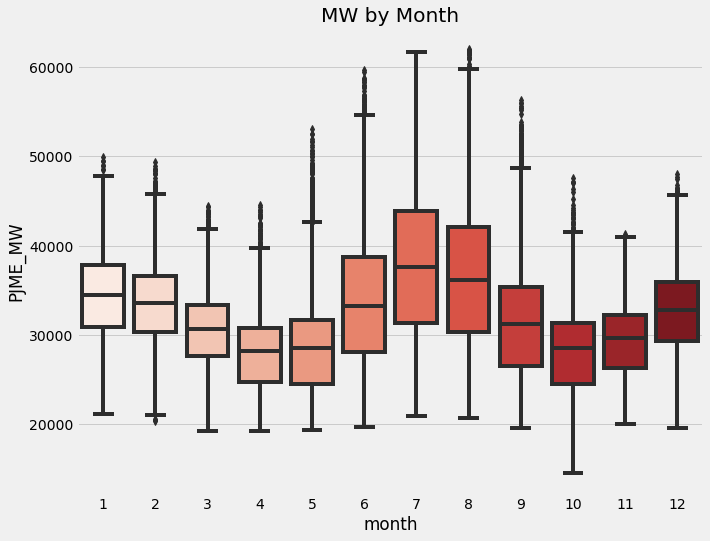

In [78]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Reds')
ax.set_title('MW by Month')
plt.show()

# Create our Model

In [79]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [80]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [88]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=1000, early_stopping_rounds=50, objective='reg:squarederror', max_depth=3, learning_rate=0.01)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:32605.13860	validation_1-rmse:31657.15907
[100]	validation_0-rmse:12581.21576	validation_1-rmse:11743.75117
[200]	validation_0-rmse:5835.12473	validation_1-rmse:5365.67712
[300]	validation_0-rmse:3915.75572	validation_1-rmse:4020.67027
[400]	validation_0-rmse:3443.16487	validation_1-rmse:3853.40425
[500]	validation_0-rmse:3285.33827	validation_1-rmse:3805.30193
[600]	validation_0-rmse:3201.92939	validation_1-rmse:3772.44905
[700]	validation_0-rmse:3148.14225	validation_1-rmse:3750.91088
[800]	validation_0-rmse:3109.24250	validation_1-rmse:3733.89694
[900]	validation_0-rmse:3079.40078	validation_1-rmse:3725.61208
[999]	validation_0-rmse:3052.73502	validation_1-rmse:3722.92243


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [89]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])

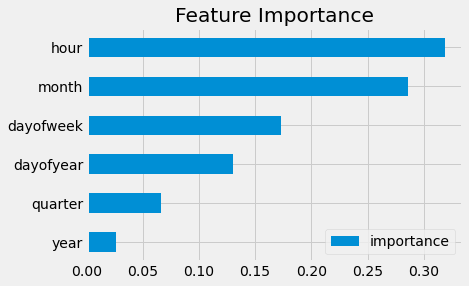

In [90]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test data

In [92]:
test['prediction'] = reg.predict(X_test)

df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

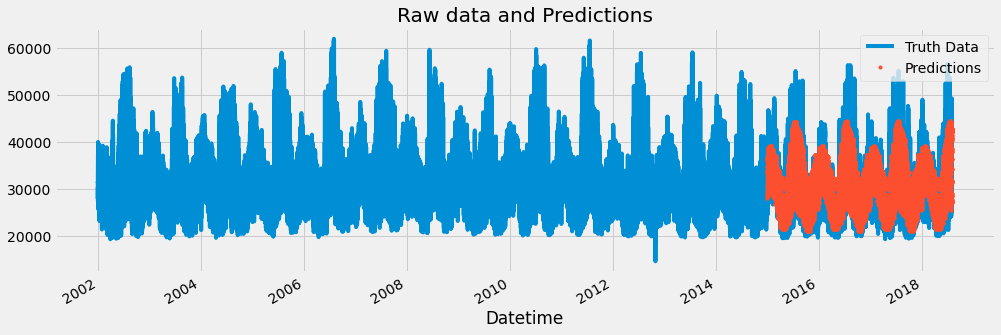

In [93]:
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw data and Predictions')
plt.show()

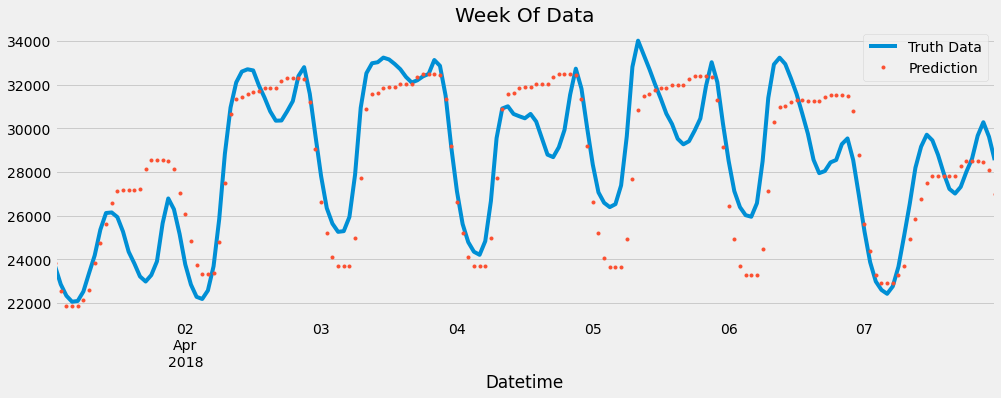

In [94]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'].plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'].plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [95]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3721.75


# Calculating Error

In [96]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [97]:
test['date'] = test.index.date

In [100]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    12839.595459
2016-08-14    12780.209554
2016-09-10    11356.302002
2015-02-20    10965.976237
2016-09-09    10864.953451
Name: error, dtype: float64

In [101]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2017-10-24    349.391520
2015-10-28    397.410563
2016-10-27    528.968994
2015-05-06    529.528483
2017-10-15    535.291748
Name: error, dtype: float64

# Next Steps
- More robust cross validation
- Add more features (weather forecast, holidays)